In [1]:
# Import the package
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertModel, AdamW
import numpy as np
import pandas as pd
from tqdm import tqdm
import xml.etree.ElementTree as ET
import nltk
from nltk.corpus import wordnet as wn

In [2]:
# Settings for loading training data
semcor_training_xml_path = 'WSD_Evaluation_Framework/Training_Corpora/Semcor/semcor.data.xml'
semcor_training_gk_path = 'WSD_Evaluation_Framework/Training_Corpora/Semcor/semcor.gold.key.txt'

In [3]:
def load_xml_data(xml_file_path=''):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    data = []
    for text in root.findall('text'):
        for sentence in text.findall('sentence'):
            sentence_id = sentence.get('id')
            sentence_text = ' '.join([element.text for element in sentence])
            for instance in sentence.findall('instance'):
                instance_id = instance.get('id')
                lemma = instance.get('lemma')
                pos = instance.get('pos')
                word = instance.text
                data.append([sentence_id, instance_id, lemma, pos, word, sentence_text])
    columns = ['sentence_id', 'instance_id', 'lemma', 'pos', 'word', 'sentence_text']
    xml_data = pd.DataFrame(data, columns=columns)
    return xml_data


# Load xml training data from semcor
semcor_training_xml = load_xml_data(semcor_training_xml_path)
display(semcor_training_xml.head())

,sentence_id,instance_id,lemma,pos,word,sentence_text
0,d000.s000,d000.s000.t000,long,ADJ,long,How long has it been since you reviewed the ob...
1,d000.s000,d000.s000.t001,be,VERB,been,How long has it been since you reviewed the ob...
2,d000.s000,d000.s000.t002,review,VERB,reviewed,How long has it been since you reviewed the ob...
3,d000.s000,d000.s000.t003,objective,NOUN,objectives,How long has it been since you reviewed the ob...
4,d000.s000,d000.s000.t004,benefit,NOUN,benefit,How long has it been since you reviewed the ob...


In [4]:
def load_gold_keys(gold_key_file_path=''):
    gold_key_data = []
    with open(gold_key_file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            instance_id = parts[0]
            sense_id = parts[1]
            gold_key_data.append([instance_id, sense_id])

    # Create a DataFrame
    gold_key_columns = ['instance_id', 'sense_id']
    gold_key_df = pd.DataFrame(gold_key_data, columns=gold_key_columns)
    return gold_key_df

# Load gold key training data from semcor
semcor_training_gk = load_gold_keys(semcor_training_gk_path)
display(semcor_training_gk.head())

,instance_id,sense_id
0,d000.s000.t000,long%3:00:02::
1,d000.s000.t001,be%2:42:03::
2,d000.s000.t002,review%2:31:00::
3,d000.s000.t003,objective%1:09:00::
4,d000.s000.t004,benefit%1:21:00::


In [5]:
# Merge data from two file
semcor_training_merged = pd.merge(semcor_training_xml, semcor_training_gk, on='instance_id', how='inner')
display(semcor_training_merged.head())

,sentence_id,instance_id,lemma,pos,word,sentence_text,sense_id
0,d000.s000,d000.s000.t000,long,ADJ,long,How long has it been since you reviewed the ob...,long%3:00:02::
1,d000.s000,d000.s000.t001,be,VERB,been,How long has it been since you reviewed the ob...,be%2:42:03::
2,d000.s000,d000.s000.t002,review,VERB,reviewed,How long has it been since you reviewed the ob...,review%2:31:00::
3,d000.s000,d000.s000.t003,objective,NOUN,objectives,How long has it been since you reviewed the ob...,objective%1:09:00::
4,d000.s000,d000.s000.t004,benefit,NOUN,benefit,How long has it been since you reviewed the ob...,benefit%1:21:00::


In [6]:
sense_id_cache = {}
def format_sense_id(sense_id):
    if sense_id not in sense_id_cache:
        sense_id_cache[sense_id] = wn.lemma_from_key(sense_id).synset().name()
    return sense_id_cache[sense_id]
    
semcor_training_merged['formatted_sense_id'] = semcor_training_merged['sense_id'].apply(format_sense_id)

# We keep those columns for now
keys_to_keep = ['lemma', 'word', 'sentence_text', 'formatted_sense_id']
semcor_training_merged = semcor_training_merged[keys_to_keep]

display(semcor_training_merged.head())

,lemma,word,sentence_text,formatted_sense_id
0,long,long,How long has it been since you reviewed the ob...,long.a.01
1,be,been,How long has it been since you reviewed the ob...,be.v.01
2,review,reviewed,How long has it been since you reviewed the ob...,review.v.01
3,objective,objectives,How long has it been since you reviewed the ob...,aim.n.02
4,benefit,benefit,How long has it been since you reviewed the ob...,benefit.n.01


In [7]:
# Setting to load nball embeddings
nball_small_path = 'training_set/nballSmall.txt'

def load_ball_embeddings(bFile):
    print("loading balls....")
    bdic=dict()
    with open(bFile, 'r') as w2v:
        for line in w2v.readlines():
            wlst = line.strip().split()
            bdic[wlst[0]] = list(map(float, wlst[1:]))
    print(len(bdic),' balls are loaded\n')
    return bdic


# Load ball embeddings
nball_small = load_ball_embeddings(nball_small_path)

# Check the length of the nball embeddings
nball_len =[]
for i, (key, value) in enumerate(nball_small.items()):
    value_len = len(nball_small[key])
    if value_len not in nball_len:
        nball_len.append(value_len)
print(f'The length of nball embeddings: {nball_len}')

loading balls....
8691  balls are loaded

The length of nball embeddings: [159]


In [8]:
# For now, we train on exist nball

print(f'Original length of the training set:{len(semcor_training_merged)}')
semcor_training = semcor_training_merged[semcor_training_merged['formatted_sense_id'].isin(nball_small.keys())].copy()
print(f'Actual data used of the training set:{len(semcor_training)}')

display(semcor_training.head())

Original length of the training set:226036
Actual data used of the training set:20032


,lemma,word,sentence_text,formatted_sense_id
6,program,program,How long has it been since you reviewed the ob...,program.n.02
10,program,program,Have you permitted it to become a giveaway pro...,program.n.02
24,program,program,What effort do you make to assess results of y...,program.n.02
46,use,using,Are you using the most economical printing met...,use.v.01
80,eating,eating,When improvements are recommended in working c...,eating.n.01


In [9]:
# Setting for the model choice
models = {
    "BERT-Base": "bert-base-uncased",
    "BERT-Large": "bert-large-uncased",
    "BERT-Medium": "google/bert_uncased_L-8_H-512_A-8",
    "BERT-Small": "google/bert_uncased_L-4_H-256_A-4",
    "BERT-Mini": "google/bert_uncased_L-4_H-128_A-2",
    "BERT-Tiny": "google/bert_uncased_L-2_H-128_A-2"
}

# With our nball dimention 159, we choose bert small with 256 dimentions
model_name = models["BERT-Small"]

In [10]:
# Get sense index
sense_labels = list(nball_small.keys())
sense_index = {sense: idx for idx, sense in enumerate(sense_labels)}
semcor_training.loc[:,'sense_idx'] = semcor_training['formatted_sense_id'].map(sense_index)

original_dim = len(nball_small[sense_labels[0]])
target_dim = 256  # Dimension of BERT-Small

# Calculate the new dimension after removing the last two elements
new_dim = original_dim - 2
padding_size = target_dim - new_dim  # Adjust padding size based on the new dimension

# Process each embedding
padded_embeddings = []
for label in sense_labels:
    # Remove the last two elements from each embedding, as too large, maybe the radius
    trimmed_embedding = nball_small[label][:-2]

    enlarged_embedding = [x * 10000 for x in trimmed_embedding]
    # Pad the trimmed embedding to match the target dimension
    padded_embedding = np.pad(enlarged_embedding, (0, padding_size), 'constant', constant_values=0)
    
    # Add to the list of padded embeddings
    padded_embeddings.append(padded_embedding)

sense_embeddings = torch.tensor(np.array(padded_embeddings), dtype=torch.float64)

print(f'Total data of nball embeddings:{len(sense_embeddings)}')
print(f'The length after padding: {len(sense_embeddings[0])}')

Total data of nball embeddings:8691
The length after padding: 256


In [11]:
# Tokenize the sentence
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name)

# Could be problem here, as we always fid
def find_word_index(sentence_ids, word):
    word_tokens = tokenizer.tokenize(word)
    word_ids = tokenizer.convert_tokens_to_ids(word_tokens)
    for i in range(len(sentence_ids) - len(word_tokens) + 1):
        if sentence_ids[i:i+len(word_tokens)].tolist() == word_ids:
            return i
    return -1

def tokenize_data(df):
    # Tokenize all sentences
    print("Tokenizing sentences...")
    tokenized_data = tokenizer(list(df['sentence_text']), padding=True, truncation=True, return_tensors="pt", max_length=512)
    input_ids = tokenized_data['input_ids']
    attention_masks = tokenized_data['attention_mask']

    # Progress bar for calculating word indices
    print("Calculating word indices...")
    # pbar = tqdm(total=df.shape[0], desc="Calculating word indices")
    word_indices = []
    for sentence_ids, word in zip(input_ids, df['word']):
        word_indices.append(find_word_index(sentence_ids, word))
        # pbar.update(1)  # Update progress for each word index found

    # print(f"Length input_ids:{len(input_ids)}\n Length attention_mask:{len(attention_masks)}\n Length \
    # word_index:{len(word_indices)}\n Length dataframe:{len(df)}")
    df.loc[:, 'input_ids'] = input_ids.tolist()
    df.loc[:, 'attention_mask'] = attention_masks.tolist()
    df.loc[:, 'word_index'] = word_indices

    print('Tokenizing finished!')
    # pbar.close()  # Close the progress bar after completion


tokenize_data(semcor_training)
display(semcor_training.head())

Tokenizing sentences...
Calculating word indices...
Tokenizing finished!


,lemma,word,sentence_text,formatted_sense_id,sense_idx,input_ids,attention_mask,word_index
6,program,program,How long has it been since you reviewed the ob...,program.n.02,2382,"[101, 2129, 2146, 2038, 2009, 2042, 2144, 2017...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",16
10,program,program,Have you permitted it to become a giveaway pro...,program.n.02,2382,"[101, 2031, 2017, 7936, 2009, 2000, 2468, 1037...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",10
24,program,program,What effort do you make to assess results of y...,program.n.02,2382,"[101, 2054, 3947, 2079, 2017, 2191, 2000, 1435...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",11
46,use,using,Are you using the most economical printing met...,use.v.01,7420,"[101, 2024, 2017, 2478, 1996, 2087, 21791, 802...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3
80,eating,eating,When improvements are recommended in working c...,eating.n.01,3194,"[101, 2043, 8377, 2024, 6749, 1999, 2551, 3785...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",16


In [12]:
# Setting, small batch size here so that do not out of cuda memory
batch_size = 2

# Create tensor dataset to speed learning
# Convert lists of lists into tensors
all_input_ids = torch.stack([torch.tensor(ids, dtype=torch.long) for ids in semcor_training['input_ids']])
all_attention_masks = torch.stack([torch.tensor(mask, dtype=torch.long) for mask in semcor_training['attention_mask']])
all_word_indices = torch.tensor(semcor_training['word_index'].tolist(), dtype=torch.long)
all_senses = torch.tensor(semcor_training['sense_idx'].tolist(), dtype=torch.long)

# Create a TensorDataset
dataset = TensorDataset(all_input_ids, all_attention_masks, all_word_indices, all_senses)

# Use DataLoader to handle batching
dataloader = DataLoader(dataset, batch_size, shuffle=True)

In [13]:
# Training the model
# Set the device to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Model setting
model = BertModel.from_pretrained(model_name).to(device)
model.train() 
sense_embeddings = sense_embeddings.to(device)  # Move sense embeddings to GPU
loss_fn = nn.CosineEmbeddingLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)


# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    total_loss = 0
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True, position=0)
    for batch in progress_bar:
        # Send batch data to the device (GPU)
        batch_input_ids, batch_attention_masks, batch_word_indices, batch_sense_indices = [b.to(device) for b in batch]

        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
        hidden_states = outputs.last_hidden_state
        
        # Retrieve embeddings for specific word indices
        word_embeddings = torch.stack([hidden_states[i, idx, :] for i, idx in enumerate(batch_word_indices)])
        
        # Retrieve the corresponding sense embeddings
        target_embeddings = sense_embeddings[batch_sense_indices]

        # Labels tensor indicating that embeddings should be similar
        labels = torch.ones(word_embeddings.size(0), device=device)

        # Calculate loss
        loss = loss_fn(word_embeddings, target_embeddings, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    print(f'Epoch {epoch + 1}, Loss: {total_loss / len(dataloader)}')

Using device: cuda


Epoch 1/3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10016/10016 [04:03<00:00, 41.09it/s, loss=0.0367]


Epoch 1, Loss: 0.11150705415005237


Epoch 2/3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10016/10016 [04:05<00:00, 40.81it/s, loss=0.00249]


Epoch 2, Loss: 0.014034002843909986


Epoch 3/3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10016/10016 [04:17<00:00, 38.83it/s, loss=0.00169]

Epoch 3, Loss: 0.003123550009616123


In [14]:
# # Load and preprocess evaluation dataset
# sem2007_eval_xml_path = 'WSD_Evaluation_Framework/Evaluation_Datasets/semeval2007/semeval2007.data.xml'
# sem2007_eval_gk_path = 'WSD_Evaluation_Framework/Evaluation_Datasets/semeval2007/semeval2007.gold.key.txt'

# sem2007_xml = load_xml_data(sem2007_eval_xml_path)
# sem2007_gk = load_gold_keys(sem2007_eval_gk_path)
# sem2007_merged = pd.merge(sem2007_xml, sem2007_gk, on='instance_id', how='inner')
# sem2007_merged['formatted_sense_id'] = sem2007_merged['sense_id'].apply(format_sense_id)
# keys_to_keep = ['lemma', 'word', 'sentence_text', 'formatted_sense_id']
# sem2007_merged = sem2007_merged[keys_to_keep]
# print(f'Original length of the eval set:{len(sem2007_merged)}')
# sem2007 = sem2007_merged[sem2007_merged['formatted_sense_id'].isin(nball_small.keys())].copy()
# print(f'Actual data used of the eval set:{len(sem2007)}')
# tokenize_data(sem2007)
# sem2007.loc[:,'sense_idx'] = sem2007['formatted_sense_id'].map(sense_index)
# display(sem2007.head())


# all_input_ids_eval = torch.stack([torch.tensor(ids, dtype=torch.long) for ids in sem2007['input_ids']])
# all_attention_masks_eval = torch.stack([torch.tensor(mask, dtype=torch.long) for mask in sem2007['attention_mask']])
# all_word_indices_eval = torch.tensor(sem2007['word_index'].tolist(), dtype=torch.long)
# all_senses_eval = torch.tensor(sem2007['sense_idx'].tolist(), dtype=torch.long)

# # Create a TensorDataset
# dataset_eval = TensorDataset(all_input_ids_eval, all_attention_masks_eval, \
#                         all_word_indices_eval, all_senses_eval)

# # Use DataLoader to handle batching
# prediction_dataloader = DataLoader(dataset_eval, batch_size, shuffle=True)


In [15]:
model.eval()

# Check if we use training set
dataloader_used = dataloader

predicted_sense_ids = []
pred_cos_sims = []  
target_cos_sims = []  

with torch.no_grad():
    for batch in dataloader_used:
        batch_input_ids, batch_attention_masks, batch_word_indices, batch_sense_indices = [b.to(device) for b in batch]

        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
        hidden_states = outputs.last_hidden_state
        
        word_embeddings = torch.stack([hidden_states[i, idx, :] for i, idx in enumerate(batch_word_indices)])
        
        # Calculate cosine similarities between word embeddings and all sense embeddings
        cosine_similarities = F.cosine_similarity(word_embeddings.unsqueeze(1), sense_embeddings.unsqueeze(0), dim=-1)
        
        # Get the index of the closest sense embedding
        predicted_indices = torch.argmax(cosine_similarities, dim=1)
        predicted_sense_ids.extend(predicted_indices.cpu().numpy())
        
        # Fetch the maximum cosine similarity values for each predicted sense
        pred_cos_sims.extend(torch.max(cosine_similarities, dim=1).values.cpu().numpy())
        
        # Calculate cosine similarity for the actual target senses
        target_embeddings = sense_embeddings[batch_sense_indices]
        target_cos_sim = F.cosine_similarity(word_embeddings, target_embeddings)
        target_cos_sims.extend(target_cos_sim.cpu().numpy())

# Assuming small_set is a DataFrame or similar
semcor_training['predicted_sense_id'] = [sense_labels[idx] for idx in predicted_sense_ids]
semcor_training['pred_cos_sim'] = pred_cos_sims
semcor_training['target_cos_sim'] = target_cos_sims

# with torch.no_grad():
#     for batch in dataloader_used:
#         batch_input_ids, batch_attention_masks, batch_word_indices, batch_sense_indices = [b.to(device) for b in batch]

#         outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
#         hidden_states = outputs.last_hidden_state
        
#         word_embeddings = torch.stack([hidden_states[i, idx, :] for i, idx in enumerate(batch_word_indices)])
        
#         # Calculate cosine similarities between word embeddings and sense embeddings
#         cosine_similarities = F.cosine_similarity(word_embeddings.unsqueeze(1), sense_embeddings.unsqueeze(0), dim=-1)
        
#         # Get the index of the closest sense embedding
#         predicted_indices = torch.argmax(cosine_similarities, dim=1)
#         sim_pre = torch.max(cosine_similarities, dim=1)
#         target_embeddings = sense_embeddings[batch_sense_indices]
#         sim_actual = F.cosine_similarity(word_embeddings, target_embeddings)
        
#         predicted_sense_ids.extend(predicted_indices.cpu().numpy())
#         cosine_sim_pre.extend(sim_pre.cpu().numpy())
#         cosine_sim_actual.extend(sim_actual.cpu().numpy())

# semcor_training['predicted_sense_id'] = [sense_labels[idx] for idx in predicted_sense_ids]

In [16]:
columns_to_display = ['formatted_sense_id', 'predicted_sense_id', 'pred_cos_sim', 'target_cos_sim']
display(semcor_training[columns_to_display].head())

,formatted_sense_id,predicted_sense_id,pred_cos_sim,target_cos_sim
6,program.n.02,make.v.46,0.999729,0.999688
10,program.n.02,abaya.n.01,0.999856,0.999764
24,program.n.02,time.n.04,0.999822,0.999730
46,use.v.01,resolve.v.06,0.999782,0.999446
80,eating.n.01,make.v.46,0.999810,0.999777


In [17]:
correct_predictions = semcor_training['formatted_sense_id'] == semcor_training['predicted_sense_id']
accuracy = correct_predictions.mean()

print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 0.04%


D:\Anaconda\envs\annotated-transformer\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
D:\Anaconda\envs\annotated-transformer\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


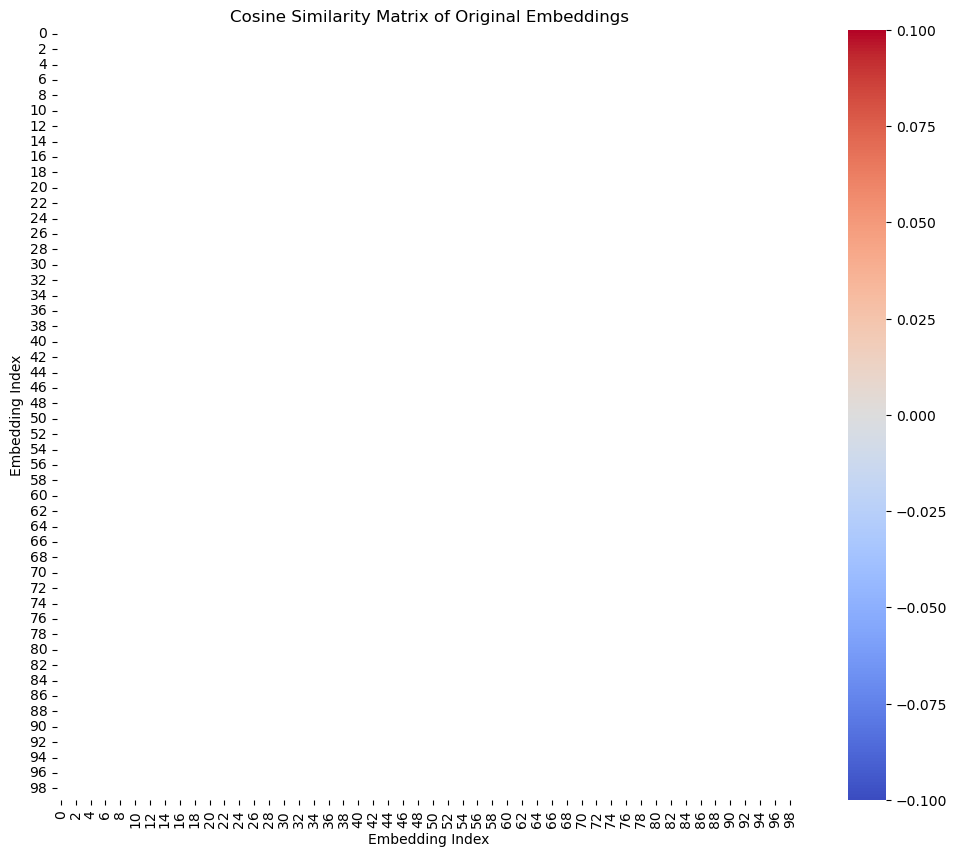

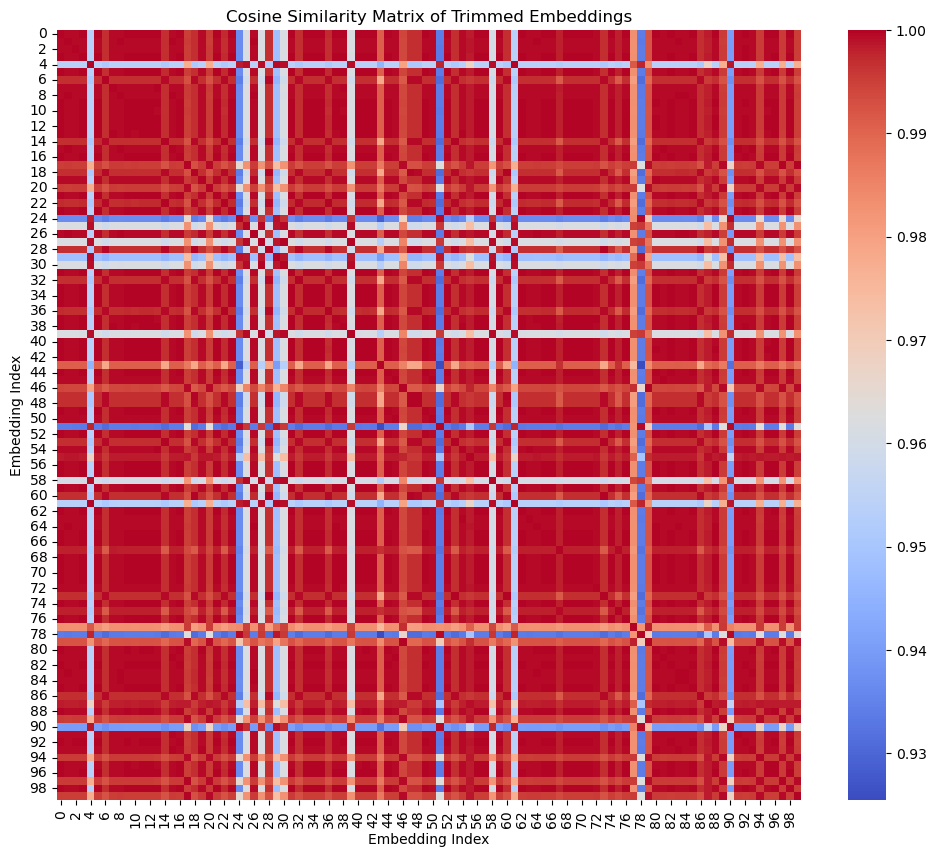

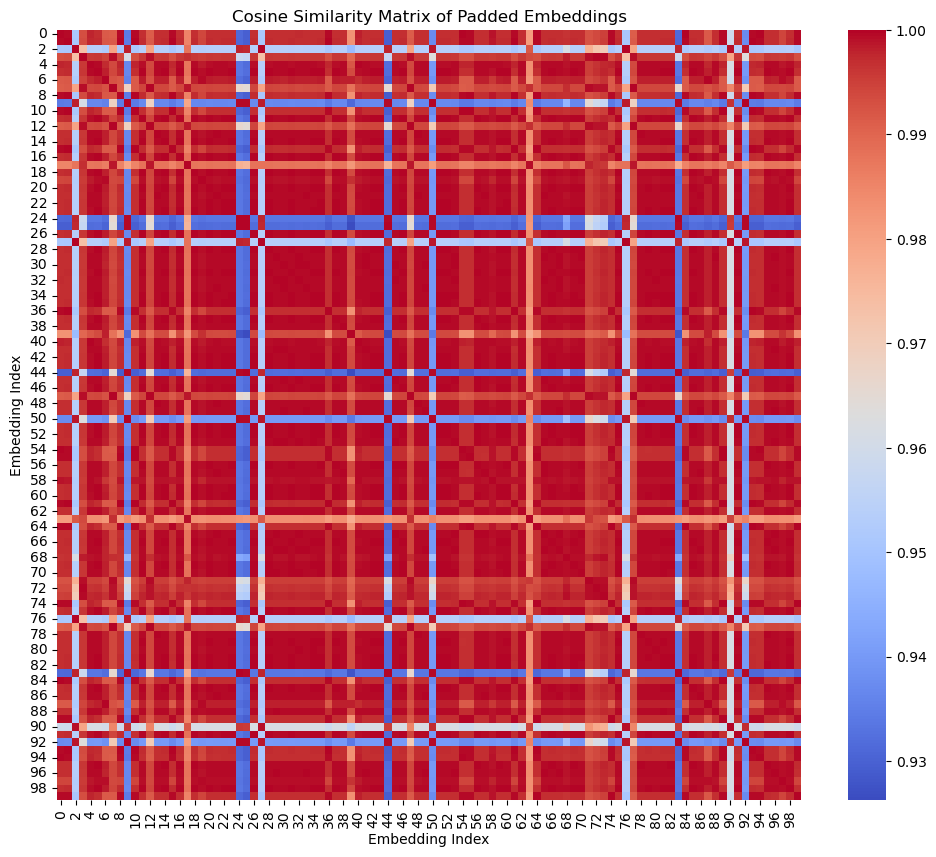

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import random

# Initialize dimensions and embeddings list
original_dim1 = len(nball_small[sense_labels[0]])
target_dim1 = 256  # Dimension of BERT-Small
padding_size1 = target_dim1 - original_dim1  # Adjust padding size correctly considering the trimming

# Assume padded_embeddings is a list of torch.Tensor objects
original_embeddings =[]
trimmed_embeddings = []
padded_embeddings = []

for label in sense_labels:
    # Ensure the embedding is in numpy array format for manipulation
    original_embedding = np.array(nball_small[label])  # Convert to numpy array if not already
    trimmed_embedding = original_embedding[:-2]  # Remove the last two elements
    # Pad the trimmed embedding to match the target dimension
    padded_embedding = np.pad(trimmed_embedding, (0, padding_size1), 'constant', constant_values=0)
    
    # Convert numpy array to tensor and add to the list of padded embeddings
    original_embeddings.append(torch.tensor(original_embedding, dtype=torch.float))
    trimmed_embeddings.append(torch.tensor(trimmed_embedding, dtype=torch.float))
    padded_embeddings.append(torch.tensor(padded_embedding, dtype=torch.float))

# Sample 100 embeddings randomly and ensure they are tensors
sampled_embeddings_original = random.sample(original_embeddings, 100)
sampled_embeddings_trimmed = random.sample(trimmed_embeddings, 100)
sampled_embeddings_padded = random.sample(padded_embeddings, 100)


# Function to plot heatmap for a given set of sampled embeddings
def plot_heatmap(sampled_embeddings, title):
    # Stack the sampled embeddings to create a matrix
    embed_matrix = torch.stack(sampled_embeddings)

    # Calculate the cosine similarity matrix
    cosine_sim_matrix = torch.nn.functional.cosine_similarity(embed_matrix.unsqueeze(1), embed_matrix.unsqueeze(0), dim=2)

    # Convert the cosine similarity matrix to a numpy array for plotting
    cosine_sim_matrix_np = cosine_sim_matrix.numpy()

    # Plotting the heatmap
    plt.figure(figsize=(12, 10))  # Adjust the size as needed
    sns.heatmap(cosine_sim_matrix_np, annot=False, cmap='coolwarm')
    plt.title(title)
    plt.xlabel('Embedding Index')
    plt.ylabel('Embedding Index')
    plt.show()

# Plot heatmaps for original, trimmed, and padded embeddings
plot_heatmap(sampled_embeddings_original, 'Cosine Similarity Matrix of Original Embeddings')
plot_heatmap(sampled_embeddings_trimmed, 'Cosine Similarity Matrix of Trimmed Embeddings')
plot_heatmap(sampled_embeddings_padded, 'Cosine Similarity Matrix of Padded Embeddings')

In [20]:
len(sense_embeddings)

8691

In [21]:
# Let's try training with random sense embeddings
sense_embeddings_rand = torch.randn((8691, 256), device=device) 


model = BertModel.from_pretrained(model_name).to(device)
model.train() 
# sense_embeddings = sense_embeddings.to(device)  # Move sense embeddings to GPU
loss_fn = nn.CosineEmbeddingLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)


# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    total_loss = 0
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True, position=0)
    for batch in progress_bar:
        # Send batch data to the device (GPU)
        batch_input_ids, batch_attention_masks, batch_word_indices, batch_sense_indices = [b.to(device) for b in batch]

        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
        hidden_states = outputs.last_hidden_state
        
        # Retrieve embeddings for specific word indices
        word_embeddings = torch.stack([hidden_states[i, idx, :] for i, idx in enumerate(batch_word_indices)])
        
        # Retrieve the corresponding sense embeddings
        target_embeddings = sense_embeddings_rand[batch_sense_indices]

        # Labels tensor indicating that embeddings should be similar
        labels = torch.ones(word_embeddings.size(0), device=device)

        # Calculate loss
        loss = loss_fn(word_embeddings, target_embeddings, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    print(f'Epoch {epoch + 1}, Loss: {total_loss / len(dataloader)}')

Epoch 1/3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10016/10016 [04:15<00:00, 39.20it/s, loss=0.494]


Epoch 1, Loss: 0.8021219290239504


Epoch 2/3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10016/10016 [04:13<00:00, 39.56it/s, loss=0.294]


Epoch 2, Loss: 0.6028103146511621


Epoch 3/3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10016/10016 [04:15<00:00, 39.27it/s, loss=0.324]

Epoch 3, Loss: 0.5037610824205005


In [23]:
model.eval()

# Check if we use training set
dataloader_used = dataloader

predicted_sense_ids = []
pred_cos_sims = []  
target_cos_sims = []  

with torch.no_grad():
    for batch in dataloader_used:
        batch_input_ids, batch_attention_masks, batch_word_indices, batch_sense_indices = [b.to(device) for b in batch]

        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
        hidden_states = outputs.last_hidden_state
        
        word_embeddings = torch.stack([hidden_states[i, idx, :] for i, idx in enumerate(batch_word_indices)])
        
        # Calculate cosine similarities between word embeddings and all sense embeddings
        cosine_similarities = F.cosine_similarity(word_embeddings.unsqueeze(1), sense_embeddings_rand.unsqueeze(0), dim=-1)
        
        # Get the index of the closest sense embedding
        predicted_indices = torch.argmax(cosine_similarities, dim=1)
        predicted_sense_ids.extend(predicted_indices.cpu().numpy())
        
        # Fetch the maximum cosine similarity values for each predicted sense
        pred_cos_sims.extend(torch.max(cosine_similarities, dim=1).values.cpu().numpy())
        
        # Calculate cosine similarity for the actual target senses
        target_embeddings = sense_embeddings_rand[batch_sense_indices]
        target_cos_sim = F.cosine_similarity(word_embeddings, target_embeddings)
        target_cos_sims.extend(target_cos_sim.cpu().numpy())


semcor_training['predicted_sense_id_rand'] = [sense_labels[idx] for idx in predicted_sense_ids]
semcor_training['pred_cos_sim_rand'] = pred_cos_sims
semcor_training['target_cos_sim_rand'] = target_cos_sims

In [24]:
columns_to_display = ['formatted_sense_id', 'predicted_sense_id_rand', 'pred_cos_sim_rand', 'target_cos_sim_rand']
display(semcor_training[columns_to_display].head())

,formatted_sense_id,predicted_sense_id_rand,pred_cos_sim_rand,target_cos_sim_rand
6,program.n.02,discontinue.v.01,0.904771,0.904771
10,program.n.02,building.n.01,0.852073,0.112974
24,program.n.02,file.n.01,0.651169,0.651169
46,use.v.01,night.n.01,0.363622,0.275917
80,eating.n.01,gram.n.01,0.360997,0.264133


In [25]:
correct_predictions = semcor_training['formatted_sense_id'] == semcor_training['predicted_sense_id']
accuracy = correct_predictions.mean()

print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 0.04%
